# Introduction

## Why Twitter Data?
Twitter is widely used to quickly spread information, however the information is not always true or important as it is also used as a normal social media. It is important to be able to quickly identify important information from this vast sea of information.

## How do we solve it?
We will use a LLM as a benchmark for performance and then use different methods of RNNs such as GRUs

## Where did this data come from?
This data came from https://www.kaggle.com/competitions/nlp-getting-started and is a collection of tweets classified as 0 for not having to do with a disaster, or 1 for a disaster

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print("CUDA Version:", tf.sysconfig.get_build_info()["cuda_version"])
print("cuDNN Version:", tf.sysconfig.get_build_info()["cudnn_version"])
print("Tensorflow Version: ", str(tf.__version__))
# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print("Available GPUs: ", gpus)

# Check if TensorFlow can access the GPU
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("TensorFlow is using the GPU!")
else:
    print("TensorFlow is NOT using the GPU.")
if gpus:
    # Get memory info for the first GPU
    memory_info = tf.config.experimental.get_memory_info('GPU:0')
    print(f"Current memory usage: {memory_info['current']} bytes")
    print(f"Peak memory usage: {memory_info['peak']} bytes")

2024-12-06 23:24:13.343828: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 23:24:13.521093: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 23:24:13.521128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 23:24:13.545378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 23:24:13.600205: I tensorflow/core/platform/cpu_feature_guar

CUDA Version: 12.2
cuDNN Version: 8
Tensorflow Version:  2.15.0
Num GPUs Available:  1
Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using the GPU!
Current memory usage: 0 bytes
Peak memory usage: 0 bytes


2024-12-06 23:24:16.240454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-06 23:24:16.276351: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-06 23:24:16.276376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-06 23:24:16.279666: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-06 23:24:16.279687: I external/local_xla/xla/stream_executor

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import nltk
import altair as alt
import seaborn as sns

In [4]:
trainData = pd.read_csv('Data/train.csv')
testData = pd.read_csv('Data/test.csv')

# EDA
In this section we will explore the data to get an idea of what we are working with before creating our models. Ideas for possible EDA comes from https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data

In [5]:
print("shape of training data is: {}".format(trainData.shape))

shape of training data is: (7613, 5)


In [6]:
display(trainData.head(5))

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Lets check the percentage of each label for our target

In [7]:
targetCounts = trainData['target'].value_counts().reset_index()
targetCounts['percentage'] = targetCounts['count'] / targetCounts['count'].sum()
# targetCounts
alt.Chart(targetCounts).mark_bar().encode(
    x = 'target:O',
    y = alt.Y('percentage:Q', scale = alt.Scale(domain=(0, 0.7))),
    tooltip = 'count'
).properties(
    title = "Percentage of natural disaster tweets",
    width = 200
)

alt.Chart(...)

Before we change any of the text (remove stop words, links, etc) lets look at the pre-processed stats

In [8]:
def getWordCount(text):
    return len(text.split())

def getNumHash(text):
    return len(text.split('#')) - 1

trainData['CharCount'] = trainData['text'].str.len()
trainData['wordCount'] = trainData['text'].apply(getWordCount)
trainData['NumOfHash'] = trainData['text'].apply(getNumHash)
trainData.head(5)

,id,keyword,location,text,target,CharCount,wordCount,NumOfHash
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,2


In [9]:
trainData[['CharCount', 'wordCount', 'NumOfHash']].describe()

,CharCount,wordCount,NumOfHash
count,7613.000000,7613.000000,7613.000000
mean,101.037436,14.903586,0.446999
std,33.781325,5.732604,1.099841
min,7.000000,1.000000,0.000000
25%,78.000000,11.000000,0.000000
50%,107.000000,15.000000,0.000000
75%,133.000000,19.000000,0.000000
max,157.000000,31.000000,13.000000


<Axes: >

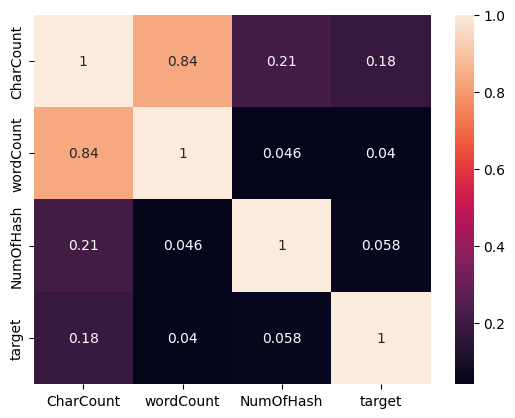

In [10]:
sns.heatmap(trainData[['CharCount', 'wordCount', 'NumOfHash', 'target']].corr(), annot=True)

There doesn't appear to be a correlation between the number of hashes, the number of words, or the number of characters to the target value.

In [11]:
import re
def removeWebpages(text, replace = True):
    url_pattern = r'https?://\S+|www\.\S+'
    # Replace the URLs with an empty string (may change to replace with a specific token since links may be important)
    replacement = 'LINK' if replace else ''
    cleaned_sentence = re.sub(url_pattern, replacement, text)
    # Strip extra spaces left after removing the link
    return cleaned_sentence.strip()

def removeTags(text, replace = True):
    tag_pattern = r'@\w+'
    replacement = 'TAG' if replace else ''
    return re.sub(tag_pattern, replacement, text).strip()

def removeEmojis(text, replace = True):
    emoji_pattern = r'[\U0001F600-\U0001F64F'  # Emoticons
    emoji_pattern += r'\U0001F300-\U0001F5FF'  # Symbols & Pictographs
    emoji_pattern += r'\U0001F680-\U0001F6FF'  # Transport & Map Symbols
    emoji_pattern += r'\U0001F1E0-\U0001F1FF'  # Flags (iOS)
    emoji_pattern += r'\U00002700-\U000027BF'  # Dingbats
    emoji_pattern += r'\U000024C2-\U0001F251'  # Enclosed Characters
    emoji_pattern += r']'
    replacement = 'EMOJI' if replace else ''
    return re.sub(emoji_pattern, replacement, text).strip()
    
# functions obtained with assistance from chatgpt

trainData['noWeb'] = trainData['text'].apply(removeWebpages)

In [12]:
def getWordFrequency(dataFrame, column: str):
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(dataFrame[column])
    sortedWordCounts = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
    sortedWordDataFrame = pd.DataFrame.from_dict(sortedWordCounts)
    sortedWordDataFrame.rename(columns={0: 'word', 1:'count'}, inplace=True)
    return sortedWordDataFrame

wordCountDF = getWordFrequency(trainData, 'noWeb')
display(wordCountDF.head(5))
#print(sortedWordCounts[:10])

,word,count
0,link,4741
1,the,3239
2,a,2195
3,in,1983
4,to,1948


<Axes: xlabel='word', ylabel='count'>

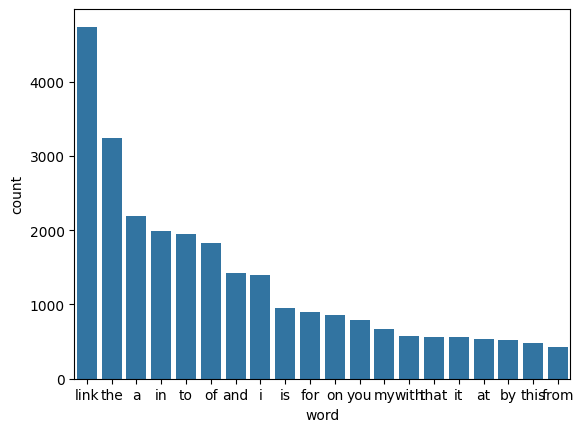

In [13]:
sns.barplot(x = wordCountDF['word'].iloc[:20], y = wordCountDF['count'].iloc[:20])

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from nltk.corpus import stopwords
def removeStopWords(text):
    text = text.lower()
    # text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    text = " ".join([word for word in text.split() if word not in stopwords.words('english')])
    return text

trainData['noStopNoWeb'] = trainData['noWeb'].apply(removeStopWords)
wordCountDF = getWordFrequency(trainData, 'noStopNoWeb')
display(wordCountDF.head(5))


,word,count
0,link,4741
1,like,348
2,amp,344
3,fire,245
4,i'm,240


<Axes: xlabel='word', ylabel='count'>

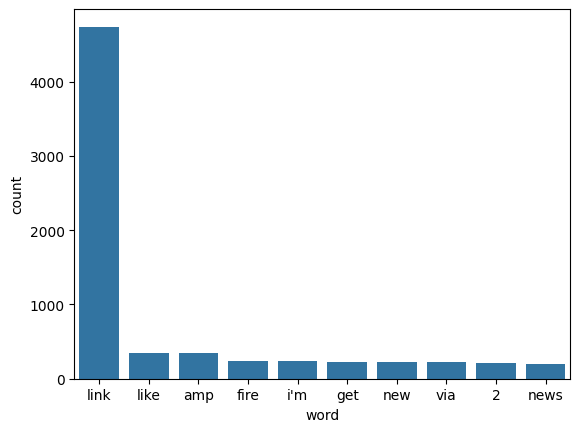

In [16]:
sns.barplot(x = wordCountDF['word'].iloc[:10], y = wordCountDF['count'].iloc[:10])

We are going to repeat one of the processes performed above but remove the links and Stopwords to see if there is now a correlation

In [17]:
trainDataFiltered = pd.read_csv('Data/train.csv')

In [18]:
trainDataFiltered['text'] = trainDataFiltered['text'].apply(removeStopWords)
trainDataFiltered['text'] = trainDataFiltered['text'].apply(removeWebpages, args=(False,))
trainDataFiltered['text'] = trainDataFiltered['text'].apply(removeTags, args=(False,))
trainDataFiltered['text'] = trainDataFiltered['text'].apply(removeEmojis, args=(False,))
display(trainDataFiltered['text'].head(5))

0        deeds reason #earthquake may allah forgive us
1               forest fire near la ronge sask. canada
2    residents asked 'shelter place' notified offic...
3    13,000 people receive #wildfires evacuation or...
4    got sent photo ruby #alaska smoke #wildfires p...
Name: text, dtype: object

In [19]:
trainDataFiltered['CharCount'] = trainDataFiltered['text'].str.len()
trainDataFiltered['wordCount'] = trainDataFiltered['text'].apply(getWordCount)
trainDataFiltered[['CharCount', 'wordCount']].describe()


,CharCount,wordCount
count,7613.000000,7613.000000
mean,65.392092,9.429266
std,26.587714,3.808321
min,0.000000,0.000000
25%,46.000000,7.000000
50%,66.000000,9.000000
75%,86.000000,12.000000
max,138.000000,27.000000


<Axes: >

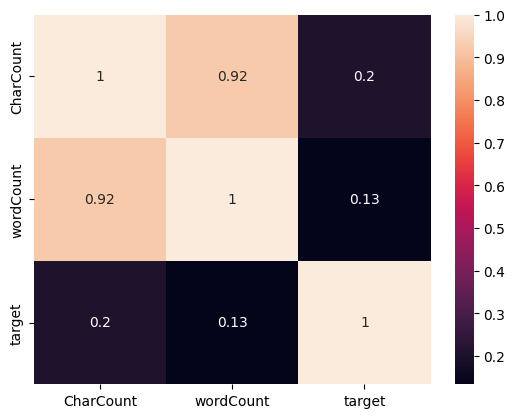

In [20]:
sns.heatmap(trainDataFiltered[['CharCount', 'wordCount', 'target']].corr(), annot=True)

We can see an increase in the correlation between character count and our target (however it is still not strong)

number of unique words: 15828


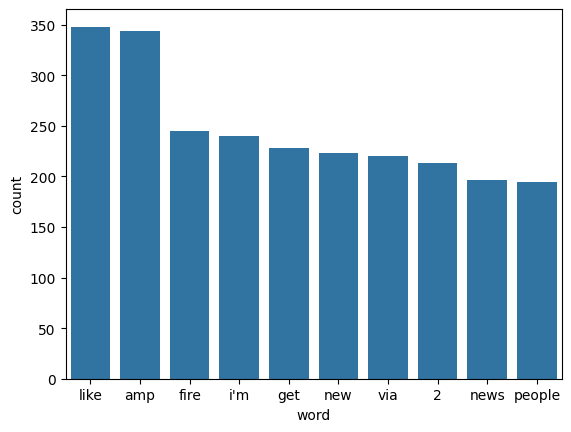

In [21]:
wordCountDF = getWordFrequency(trainDataFiltered, 'text')
sns.barplot(x = wordCountDF['word'].iloc[:10], y = wordCountDF['count'].iloc[:10])
print("number of unique words: {}".format(wordCountDF.shape[0]))

As we can see, there are a lot of links and tags in our data and we may need to remove these in the future.

### Create a train and validation split for the data

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(trainDataFiltered['text'], trainDataFiltered['target'], test_size=.2, random_state=42)

In [23]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(trainDataFiltered[['text', 'target']], test_size=.2, random_state=42)

In [24]:
display(x_train.head(5))

4996    courageous honest analysis need use atomic bom...
3263    wld b shame golf cart became engulfed flames. ...
4907    tell  rescind medals 'honor' given us soldiers...
2855    worried ca drought might affect you? extreme w...
4716            lava blast &amp; power red #pantherattack
Name: text, dtype: object

# Model Creation



## BERT LLM
First lets create a model from the LLM BERT. We will be using the tokenizer associated with it and the outcome will be our baseline score for our simpler models built from scratch.

Most of this proccess was found through hugging-face tutorials/ guides.

1. First lets load in the tokenizer for the bert model

In [25]:
from transformers import AutoTokenizer
BertTokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

2. Next we need a function to map the text to an output of input_ids and attention masking

In [26]:
def preprocess_function(examples):
    return BertTokenizer(examples["text"], truncation=True)


3. Next we will reload the data as a dataset object, use our map function, and rename the target column to label (This is because the model searches for "Label" to use as its y value)

In [27]:
import datasets
train = datasets.Dataset.from_pandas(train)
val = datasets.Dataset.from_pandas(val)
tokenizedTrain = train.map(preprocess_function, batched=True)
tokenizedVal = val.map(preprocess_function, batched=True)
tokenizedTrain = tokenizedTrain.rename_column("target", "label")
tokenizedVal = tokenizedVal.rename_column("target", "label")

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [28]:
tokenizedTrain.column_names

['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']

From hugging-face documentation: 

Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of train_dataset or eval_dataset.

In [29]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=BertTokenizer, return_tensors="tf")

The function bellow can be used to create our own metrics, however since it is binary class classification we will not need one from scratch.

In [30]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Next we will create 2 dictionary objects, One to convert the label text and the other to go back

In [31]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

Like our tensorflow models, we will need an optimizer. We will create it using the transformers "create_optimizer" function. 

https://huggingface.co/docs/transformers/en/main_classes/optimizer_schedules

In [32]:
from transformers import create_optimizer
# import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

Finally, we can load in our bert model for classification

In [33]:
from transformers import TFAutoModelForSequenceClassification

BertModel = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

We have to prepare our data as a tf dataset in order to pass it as input to our model.

In [34]:
tf_train_set = BertModel.prepare_tf_dataset(
    tokenizedTrain,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

prepare_tf_dataset: https://huggingface.co/docs/transformers/v4.46.3/en/main_classes/model#transformers.TFPreTrainedModel.prepare_tf_dataset

to_tf_dataset: https://huggingface.co/docs/datasets/v3.1.0/en/package_reference/main_classes#datasets.Dataset.to_tf_dataset

In [35]:
tf_validation_set = BertModel.prepare_tf_dataset(
    tokenizedVal,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [36]:
from tensorflow.keras.metrics import Accuracy
BertModel.compile(optimizer=optimizer, metrics=['accuracy'])

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience=5,
    restore_best_weights=True,
    start_from_epoch=1
)
BertModel.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=20, callbacks=[early_stopping])

Epoch 1/20


2024-12-06 23:24:38.531647: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f21b8b754f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-06 23:24:38.531680: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-12-06 23:24:38.541706: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-06 23:24:38.565975: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1733527478.612600     158 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


380/380 [==============================] - 36s 61ms/step - loss: 0.4537 - accuracy: 0.7992 - val_loss: 0.3985 - val_accuracy: 0.8372
Epoch 2/20
380/380 [==============================] - 19s 49ms/step - loss: 0.3328 - accuracy: 0.8643 - val_loss: 0.4172 - val_accuracy: 0.8273
Epoch 3/20
380/380 [==============================] - 17s 45ms/step - loss: 0.2394 - accuracy: 0.9115 - val_loss: 0.4787 - val_accuracy: 0.8155
Epoch 4/20
380/380 [==============================] - 18s 47ms/step - loss: 0.1755 - accuracy: 0.9398 - val_loss: 0.5249 - val_accuracy: 0.8162
Epoch 5/20
380/380 [==============================] - 19s 49ms/step - loss: 0.1330 - accuracy: 0.9579 - val_loss: 0.5829 - val_accuracy: 0.8135
Epoch 6/20
380/380 [==============================] - 18s 47ms/step - loss: 0.1173 - accuracy: 0.9609 - val_loss: 0.5829 - val_accuracy: 0.8135
Epoch 7/20
380/380 [==============================] - 18s 46ms/step - loss: 0.1197 - accuracy: 0.9604 - val_loss: 0.5829 - val_accuracy: 0.8135


# Testing building model from scratch

First we need to create a way to convert the words into an actual value that the model can read. The easiest way to do this is using tokenizers to convert each word into a numeric value and pad the sequences to a given length.

In [38]:
VOCAB_SIZE = 7500

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=7500, oov_token="<UNK>")
tokenizer.fit_on_texts(trainDataFiltered['text'])

In [39]:
trainSequence = tokenizer.texts_to_sequences(x_train)
validateSequence = tokenizer.texts_to_sequences(x_val)

In [40]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
trainSequence = pad_sequences(trainSequence, maxlen=30, padding='post')
validateSequence = pad_sequences(validateSequence, maxlen = 30, padding='post')

Load in GloVe for the embedding matrix

GloVe embeddings use the idea of the probability of a word showing given another word showed up p(f|x). 

In [41]:
import gensim.downloader as api
# load in GloVe for embeddings
glove_model = api.load("glove-wiki-gigaword-300")  # GloVe embeddings with 300 dimensions

Glove_embedding_dim = glove_model.vector_size
word_index = tokenizer.word_index
num_words = min(VOCAB_SIZE, len(word_index) + 1)
Glove_embedding_matrix = np.zeros((num_words, Glove_embedding_dim))

for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = glove_model[word] if word in glove_model else None
        if embedding_vector is not None:
            Glove_embedding_matrix[i] = embedding_vector
        else:
            Glove_embedding_matrix[i] = np.random.normal(size=(Glove_embedding_dim,))

Load in Word2Vec for the embedding matrix

Word2Vec is an embedding space where we vectorize each word into n-dimensions, where each dimension can have a different meaning such as good or bad, big or small, etc depending on the direction that you move. You can then reach a word in this space by adding or subtracting words together. An example of this would be "knight" + "Japan" = "samurai" or similar.

In [42]:
import gensim.downloader as api

word2Vec_model = api.load("word2vec-google-news-300")  # GloVe embeddings with 300 dimensions

Word2Vec_embedding_dim = word2Vec_model.vector_size
word_index = tokenizer.word_index
num_words = min(VOCAB_SIZE, len(word_index) + 1)
Word2Vec_embedding_matrix = np.zeros((num_words, Word2Vec_embedding_dim))

for word, i in word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = word2Vec_model[word] if word in word2Vec_model else None
        if embedding_vector is not None:
            Word2Vec_embedding_matrix[i] = embedding_vector
        else:
            Word2Vec_embedding_matrix[i] = np.random.normal(size=(Word2Vec_embedding_dim,))

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, Dropout, LSTM, Bidirectional

First we will try a model in which we use a new embedding matrix that has not been trained on anything yet and attempting to train it on the Twitter data.

In [58]:
SimpleEmbeddingModel = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim=100),
    SimpleRNN(64, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
SimpleEmbeddingModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [59]:
SimpleEmbeddingModel.fit(trainSequence, y_train, epochs=20, batch_size=16, validation_data=(validateSequence, y_val), callbacks=[early_stopping])

Epoch 1/20
381/381 [==============================] - 23s 55ms/step - loss: 0.6935 - accuracy: 0.5440 - val_loss: 0.6831 - val_accuracy: 0.5732
Epoch 2/20
381/381 [==============================] - 16s 41ms/step - loss: 0.6864 - accuracy: 0.5672 - val_loss: 0.6829 - val_accuracy: 0.5739
Epoch 3/20
381/381 [==============================] - 15s 40ms/step - loss: 0.6852 - accuracy: 0.5706 - val_loss: 0.6831 - val_accuracy: 0.5739
Epoch 4/20
381/381 [==============================] - 14s 37ms/step - loss: 0.6860 - accuracy: 0.5670 - val_loss: 0.6804 - val_accuracy: 0.5739
Epoch 5/20
381/381 [==============================] - 15s 39ms/step - loss: 0.6848 - accuracy: 0.5683 - val_loss: 0.6868 - val_accuracy: 0.5739
Epoch 6/20
381/381 [==============================] - 14s 38ms/step - loss: 0.6846 - accuracy: 0.5683 - val_loss: 0.6821 - val_accuracy: 0.5739
Epoch 7/20
381/381 [==============================] - 15s 40ms/step - loss: 0.6842 - accuracy: 0.5700 - val_loss: 0.6830 - val_accuracy:

From our simple model, we can see that it can't actually learn the relationship between what tweets contain information about natural disasters and which don't. We can attempt to use different RNN cells such as gated recurrent units (GRU) in order to see if this improves the models ability to interpret the text.

In [60]:
SimpleEmbeddingModel2 = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim=100),
    GRU(64, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
SimpleEmbeddingModel2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [61]:
SimpleEmbeddingModel2.fit(trainSequence, y_train, epochs=20, batch_size=16, validation_data=(validateSequence, y_val), callbacks=[early_stopping])

Epoch 1/20
381/381 [==============================] - 40s 101ms/step - loss: 0.6855 - accuracy: 0.5683 - val_loss: 0.6829 - val_accuracy: 0.5739
Epoch 2/20
381/381 [==============================] - 35s 91ms/step - loss: 0.6847 - accuracy: 0.5695 - val_loss: 0.6823 - val_accuracy: 0.5739
Epoch 3/20
381/381 [==============================] - 37s 97ms/step - loss: 0.6850 - accuracy: 0.5672 - val_loss: 0.6830 - val_accuracy: 0.5739
Epoch 4/20
381/381 [==============================] - 34s 90ms/step - loss: 0.5282 - accuracy: 0.7384 - val_loss: 0.5030 - val_accuracy: 0.7800
Epoch 5/20
381/381 [==============================] - 34s 89ms/step - loss: 0.3151 - accuracy: 0.8773 - val_loss: 0.5065 - val_accuracy: 0.7794
Epoch 6/20
381/381 [==============================] - 33s 87ms/step - loss: 0.2181 - accuracy: 0.9241 - val_loss: 0.6402 - val_accuracy: 0.7584
Epoch 7/20
381/381 [==============================] - 33s 86ms/step - loss: 0.1458 - accuracy: 0.9511 - val_loss: 0.6580 - val_accuracy

We see that this new model is able to learn an accurate embedding to classify the tweets as containing information about a natural disaster or not, however as the model is trained longer it begins to overfit. Because of this, we will decrease the output_dim in the embedding matrix, increase the dropout amount, and add a bidirectional modifier to the model.

In [62]:
SimpleEmbeddingModel3 = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim=50),
    Bidirectional(GRU(64, recurrent_dropout=0.3)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
SimpleEmbeddingModel3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [63]:
SimpleEmbeddingModel3.fit(trainSequence, y_train, epochs=20, batch_size=16, validation_data=(validateSequence, y_val), callbacks=[early_stopping])

Epoch 1/20
381/381 [==============================] - 73s 186ms/step - loss: 0.5371 - accuracy: 0.7194 - val_loss: 0.4382 - val_accuracy: 0.8063
Epoch 2/20
381/381 [==============================] - 64s 168ms/step - loss: 0.3308 - accuracy: 0.8660 - val_loss: 0.4828 - val_accuracy: 0.7748
Epoch 3/20
381/381 [==============================] - 62s 163ms/step - loss: 0.2236 - accuracy: 0.9187 - val_loss: 0.5386 - val_accuracy: 0.7820
Epoch 4/20
381/381 [==============================] - 63s 164ms/step - loss: 0.1534 - accuracy: 0.9479 - val_loss: 0.6326 - val_accuracy: 0.7708
Epoch 5/20
381/381 [==============================] - 63s 164ms/step - loss: 0.1090 - accuracy: 0.9626 - val_loss: 0.8215 - val_accuracy: 0.7505
Epoch 6/20
381/381 [==============================] - 63s 166ms/step - loss: 0.0795 - accuracy: 0.9711 - val_loss: 1.0488 - val_accuracy: 0.7551
Epoch 7/20
381/381 [==============================] - 68s 179ms/step - loss: 0.0654 - accuracy: 0.9741 - val_loss: 1.1589 - val_ac

This model again performs better but begins to overfit the data as more epochs are performed.

In [44]:
# Build the model
Glove_model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=Glove_embedding_dim,
              weights = [Glove_embedding_matrix],
              input_length = 30,
              trainable=False),
    Bidirectional(GRU(64, activation='relu', recurrent_dropout=0.3)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

In [45]:
Glove_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           2250000   
                                                                 
 bidirectional (Bidirection  (None, 128)               140544    
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2394705 (9.14 MB)
Trainable params: 144705 (565.25 KB)
Non-trainable params: 2250000 (8.58 MB)
_____________

In [46]:
# Compile the model
Glove_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
Glove_model.fit(trainSequence, y_train, epochs=20, batch_size=16, validation_data=(validateSequence, y_val), callbacks=[early_stopping])

Epoch 1/20
381/381 [==============================] - 62s 155ms/step - loss: 0.5216 - accuracy: 0.7521 - val_loss: 0.4301 - val_accuracy: 0.8207
Epoch 2/20
381/381 [==============================] - 59s 154ms/step - loss: 0.4229 - accuracy: 0.8194 - val_loss: 0.4340 - val_accuracy: 0.8129
Epoch 3/20
381/381 [==============================] - 58s 153ms/step - loss: 0.3788 - accuracy: 0.8473 - val_loss: 0.4392 - val_accuracy: 0.8155
Epoch 4/20
381/381 [==============================] - 58s 152ms/step - loss: 0.3358 - accuracy: 0.8580 - val_loss: 0.4615 - val_accuracy: 0.8142
Epoch 5/20
381/381 [==============================] - 65s 170ms/step - loss: 0.3004 - accuracy: 0.8749 - val_loss: 0.4942 - val_accuracy: 0.7965
Epoch 6/20
381/381 [==============================] - 62s 162ms/step - loss: 0.2719 - accuracy: 0.8864 - val_loss: 0.5898 - val_accuracy: 0.7827
Epoch 7/20
381/381 [==============================] - 59s 154ms/step - loss: 0.2327 - accuracy: 0.9062 - val_loss: 0.5984 - val_ac

Testing the same code with Word2Vec instead of GloVe

In [47]:
word2vec_model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=Word2Vec_embedding_dim,
              weights = [Word2Vec_embedding_matrix],
              input_length = 30,
              trainable=False),
    Bidirectional(GRU(64, activation='relu', recurrent_dropout=0.3)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])
word2vec_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
word2vec_model.fit(trainSequence, y_train, epochs=20, batch_size=16, validation_data=(validateSequence, y_val), callbacks=[early_stopping])

Epoch 1/20
381/381 [==============================] - 61s 154ms/step - loss: 0.5669 - accuracy: 0.7246 - val_loss: 0.4728 - val_accuracy: 0.7938
Epoch 2/20
381/381 [==============================] - 60s 157ms/step - loss: 0.4360 - accuracy: 0.8082 - val_loss: 0.4545 - val_accuracy: 0.8011
Epoch 3/20
381/381 [==============================] - 63s 164ms/step - loss: 0.3962 - accuracy: 0.8325 - val_loss: 0.4565 - val_accuracy: 0.7971
Epoch 4/20
381/381 [==============================] - 60s 157ms/step - loss: 0.3694 - accuracy: 0.8463 - val_loss: 0.4606 - val_accuracy: 0.8056
Epoch 5/20
381/381 [==============================] - 59s 155ms/step - loss: 0.3481 - accuracy: 0.8521 - val_loss: 0.4697 - val_accuracy: 0.8030
Epoch 6/20
381/381 [==============================] - 59s 155ms/step - loss: 0.3288 - accuracy: 0.8621 - val_loss: 0.5114 - val_accuracy: 0.7938
Epoch 7/20
381/381 [==============================] - 59s 154ms/step - loss: 0.3131 - accuracy: 0.8713 - val_loss: 0.5092 - val_ac

Next we will check if making the embedding matrix tuneable will help our performance

In [48]:
Glove_model_tuneable = Sequential([
    Embedding(input_dim=num_words,
              output_dim=Glove_embedding_dim,
              weights = [Glove_embedding_matrix],
              input_length = 30,
              trainable=True),
    Bidirectional(GRU(64, activation='relu', recurrent_dropout=0.3)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])
Glove_model_tuneable.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy'])
Glove_model_tuneable.fit(trainSequence, y_train, epochs=20, batch_size=16, validation_data=(validateSequence, y_val), callbacks=[early_stopping])

Epoch 1/20
381/381 [==============================] - 73s 183ms/step - loss: 0.5192 - accuracy: 0.7491 - val_loss: 0.4283 - val_accuracy: 0.8162
Epoch 2/20
381/381 [==============================] - 63s 165ms/step - loss: 0.3596 - accuracy: 0.8521 - val_loss: 0.4396 - val_accuracy: 0.8102
Epoch 3/20
381/381 [==============================] - 62s 163ms/step - loss: 0.2679 - accuracy: 0.8926 - val_loss: 0.4877 - val_accuracy: 0.7912
Epoch 4/20
381/381 [==============================] - 63s 164ms/step - loss: 0.1866 - accuracy: 0.9238 - val_loss: 0.6592 - val_accuracy: 0.7859
Epoch 5/20
381/381 [==============================] - 67s 175ms/step - loss: 0.1243 - accuracy: 0.9511 - val_loss: 0.8723 - val_accuracy: 0.7689
Epoch 6/20
381/381 [==============================] - 67s 175ms/step - loss: 0.0907 - accuracy: 0.9632 - val_loss: 0.9581 - val_accuracy: 0.7722
Epoch 7/20
381/381 [==============================] - 63s 165ms/step - loss: 0.0679 - accuracy: 0.9719 - val_loss: 0.9854 - val_ac

In [49]:
word2vec_model_tuneable = Sequential([
    Embedding(input_dim=num_words,
              output_dim=Word2Vec_embedding_dim,
              weights = [Word2Vec_embedding_matrix],
              input_length = 30,
              trainable=True),
    Bidirectional(GRU(64, activation='relu', recurrent_dropout=0.3)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])
word2vec_model_tuneable.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
word2vec_model_tuneable.fit(trainSequence, y_train, epochs=20, batch_size=16, validation_data=(validateSequence, y_val), callbacks=[early_stopping])

Epoch 1/20
381/381 [==============================] - 69s 175ms/step - loss: 0.5329 - accuracy: 0.7360 - val_loss: 0.4397 - val_accuracy: 0.8024
Epoch 2/20
381/381 [==============================] - 63s 166ms/step - loss: 0.3526 - accuracy: 0.8567 - val_loss: 0.4757 - val_accuracy: 0.7886
Epoch 3/20
381/381 [==============================] - 64s 168ms/step - loss: 0.2494 - accuracy: 0.9031 - val_loss: 0.5260 - val_accuracy: 0.7866
Epoch 4/20
381/381 [==============================] - 68s 178ms/step - loss: 0.1722 - accuracy: 0.9348 - val_loss: 0.6343 - val_accuracy: 0.7722
Epoch 5/20
381/381 [==============================] - 65s 170ms/step - loss: 0.1133 - accuracy: 0.9558 - val_loss: 0.9381 - val_accuracy: 0.7597
Epoch 6/20
381/381 [==============================] - 66s 174ms/step - loss: 0.0830 - accuracy: 0.9673 - val_loss: 1.1221 - val_accuracy: 0.7492
Epoch 7/20
381/381 [==============================] - 64s 167ms/step - loss: 0.0710 - accuracy: 0.9718 - val_loss: 1.2662 - val_ac

We can see that allowing the embedding matrix to be tuneable leads to overfitting and a decrease on our validation data.

# Results and Analysis

## Helper functions

In [50]:
from sklearn import metrics
def displayMetrics(predictions, y_true, modelName):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, predictions)
    roc_auc = metrics.auc(fpr,tpr)
    display = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc=roc_auc, estimator_name=modelName)
    display.plot()
    plt.title("ROC Curve for {}".format(modelName))
    plt.show()
    precision, recall, _ = metrics.precision_recall_curve(y_true, predictions)
    disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title("Precision Vs Recall for {}".format(modelName))
    plt.show()

    metrics.ConfusionMatrixDisplay.from_predictions(y_true, np.round(predictions.reshape(None,)))
    plt.title("{} Confusion Matrix".format(modelName))
    plt.show()

    print("Precision score: {}\nRecall score: {}".format(
        metrics.precision_score(y_true, np.round(predictions.reshape(None,))), metrics.recall_score(y_true, np.round(predictions.reshape(None,)))
    ))

In [113]:
def displayROCMultiple(modelPredictions: list, y_true_list: list, modelNames: list):
    plt.figure()
    for i in range(len(modelNames)):
        predictions = modelPredictions[i]
        y_true = y_true_list[i]
        modelName = modelNames[i]
        fpr, tpr, thresholds = metrics.roc_curve(y_true, predictions)
        roc_auc = metrics.auc(fpr,tpr)
        plt.plot(fpr, tpr, label="{} : (AUC = {:.2f})".format(modelName, roc_auc))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Models")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [132]:
def displayPrecisionVsRecallMultiple(modelPredictions: list, y_true_list: list, modelNames: list):
    plt.figure()
    for i in range(len(modelNames)):
        predictions = modelPredictions[i]
        y_true = y_true_list[i]
        modelName = modelNames[i]
        precision, recall, _ = metrics.precision_recall_curve(y_true, predictions)
        plt.plot(recall, precision, label = "{}: Precision: {:.2f}, Recall: {:.2f}".format(modelName, 
                                                                                           metrics.precision_score(y_true, np.round(predictions.reshape(None,))), 
                                                                                           metrics.recall_score(y_true, np.round(predictions.reshape(None,)))))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision vs Recall for Models")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

In [123]:
def displayConfusionMatrixSingle(modelPredictions: list, y_true_list: list, modelNames: list):
    fig, axes = plt.subplots(nrows = (len(modelNames)+1) // 2, ncols = 2, figsize = (12,6))
    col = 0
    axes = axes.ravel()
    for i in range(len(modelNames)):
        predictions = modelPredictions[i]
        y_true = y_true_list[i]
        modelName = modelNames[i]
        metrics.ConfusionMatrixDisplay.from_predictions(y_true, np.round(predictions.reshape(None,)), ax=axes[i])
        axes[i].set_title("{} Confusion Matrix".format(modelName))
    for j in range(len(modelNames), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

In [103]:
modelPredictions = []
y_true_list = []
modelNames = []

# Bert Model
predictions = BertModel.predict(tf_validation_set) # return values are logits so we must convert to class probabilities
probabilities = tf.nn.softmax(predictions.logits, axis = 1).numpy()
classPredictions = probabilities[:,1]
modelPredictions.append(classPredictions)
y_true_list.append(tokenizedVal['label'])
modelNames.append("Bert LLM Model")

# SimpleModel3
modelPredictions.append(SimpleEmbeddingModel3.predict(validateSequence)[:,0])
y_true_list.append(y_val)
modelNames.append("Simple Model 3")

# Glove Model
modelPredictions.append(Glove_model.predict(validateSequence)[:,0])
y_true_list.append(y_val)
modelNames.append("GloVe Model")

# Word2Vec Model
modelPredictions.append(word2vec_model.predict(validateSequence)[:,0])
y_true_list.append(y_val)
modelNames.append("Word2Vec Model")

48/48 [==============================] - 1s 16ms/step


## ROC Curves

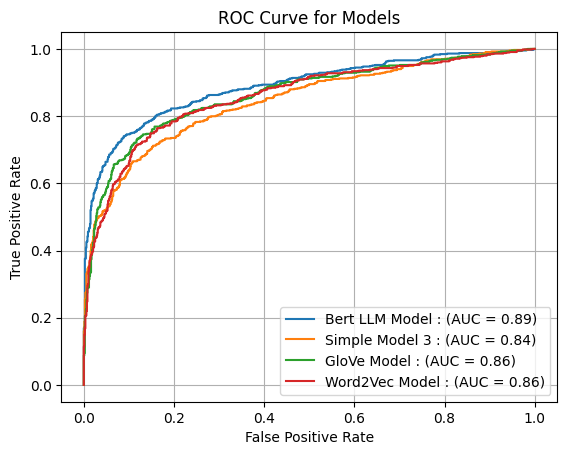

In [114]:
displayROCMultiple(modelPredictions, y_true_list, modelNames)

## Precision Recall Curves

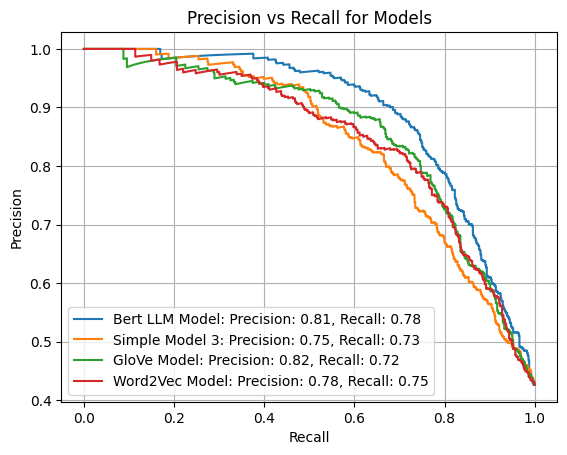

In [133]:
displayPrecisionVsRecallMultiple(modelPredictions, y_true_list, modelNames)

## Confusion Matrices

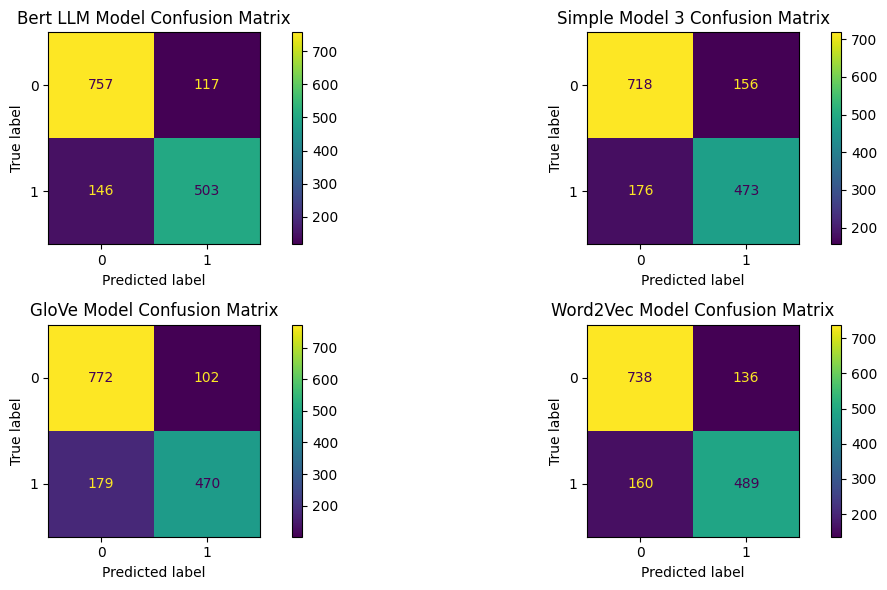

In [124]:
displayConfusionMatrixSingle(modelPredictions, y_true_list, modelNames)

## Analysis
We can see that the Bert model performed better in every metric than the rest of the models, with our simple Model only being slightly worse than the pretrained embedding models such as Glove and Word2Vec. 

# Discussion and Conclusions
I believe that the Bert language model was the best performing because it had already been trained for semantic analysis. It uses state of the art methods to create an accurate embedding matrix. While I did not expect our smaller and simpler methods to be able to predict as accurately as the LLM, our models trained with the Glove embeddings, Word2Vec embeddings, and even embeddings from scratch were able to perform closely to this model. Some methods that assisted in this was including Bidirectional cells and using GRU cells instead of standard recurrence cells. I believe this allowed the model to understand more context from the tweet rather than possibly memorizing the location of a word related to natural disaster in the tweet.

## Limitations
One of the limitations of our project was the initial limited experience with LLM's and modeling text sequences. 

## Future
In the future I would like to experiment with different size embedding matrices, different forms of data preprocessing on text, and different LLM models that may be more suited to this problem (Bert was benchmark used in guide to problem)

# References
1. https://www.kaggle.com/competitions/nlp-getting-started
2. https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data
3. https://www.huggingface.co/docs/transformers/en/training
4. https://huggingface.co/docs/transformers/en/main_classes/optimizer_schedules
5. https://huggingface.co/docs/transformers/v4.46.3/en/main_classes/model#transformers.TFPreTrainedModel.prepare_tf_dataset
6. https://jonathan-hui.medium.com/nlp-word-embedding-glove-5e7f523999f6
7. https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673